## SQLAlchemy: Climate Analysis & Exploration
Conduct climate analysis and data exploration of the provided database (hawaii.sqlite) using Python, SQLAlchemy ORM queries, Pandas, and Matplotlib.

In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

### Reflect Tables into SQLAlchemy ORM

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [4]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
M = base.classes.measurement
S = base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [8]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
selection = [M.id, M.station, M.date, M.prcp, M.tobs, S.id, S.station, S.name, S.latitude, S.longitude, S.elevation]

joint = session.query(*selection).filter(M.id == S.id).limit(10).all()

### Precipitation Analysis

In [11]:
## Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_point = session.query(M.date).order_by(M.date.desc()).first()
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(M.date, M.prcp).filter(M.date >= query_date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='date').fillna(0)
cleaned_df = results_df.rename(columns = {'date': 'Date','prcp':'Precipitation'})
# cleaned_df['Date'] = pd.to_datetime(cleaned_df['Date'],infer_datetime_format=True)
cleaned_df.set_index(cleaned_df['Date'],inplace=True)
cleaned_df

,Date,Precipitation
Date,,
2016-08-23,2016-08-23,0.00
2016-08-23,2016-08-23,0.00
2016-08-23,2016-08-23,1.79
2016-08-23,2016-08-23,0.05
2016-08-23,2016-08-23,0.15
...,...,...
2017-08-22,2017-08-22,0.00
2017-08-23,2017-08-23,0.00
2017-08-23,2017-08-23,0.00


<IPython.core.display.Javascript object>


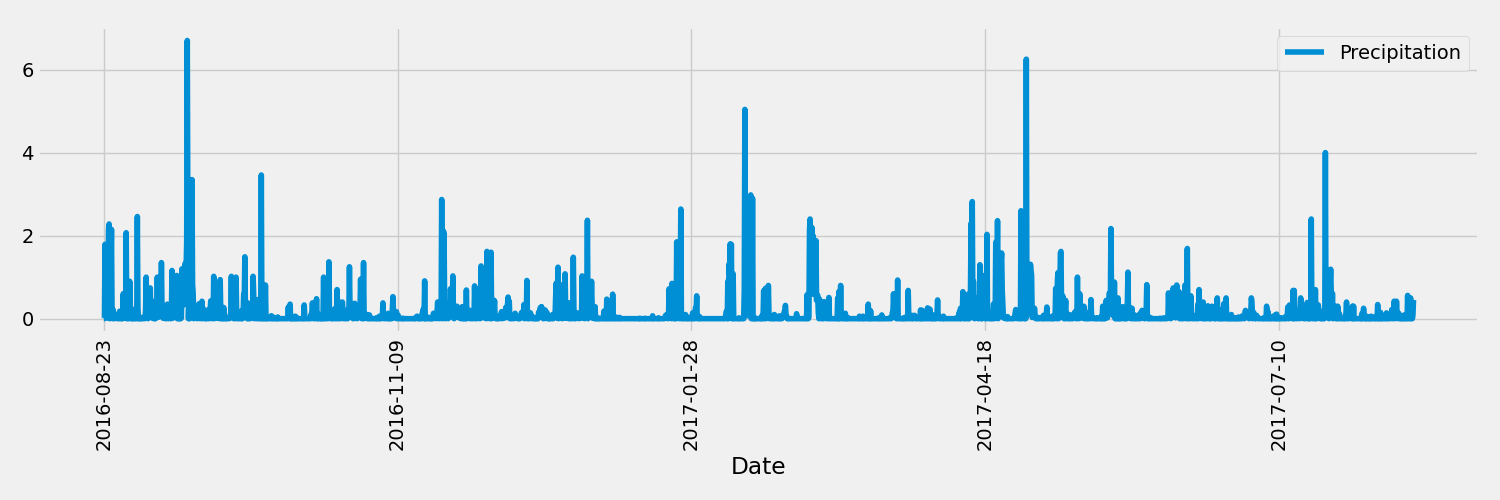

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
cleaned_df.plot(figsize=[15,5], rot=90)
plt.tight_layout()
plt.savefig("Precipitation.png")

In [13]:
## Use Pandas to calcualte the summary statistics for the precipitation data
cleaned_df.describe()

,Precipitation
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


**Summary Statistics:**

In [14]:
mean = cleaned_df['Precipitation'].mean()
median = cleaned_df['Precipitation'].median()
var = cleaned_df['Precipitation'].var()
std = cleaned_df['Precipitation'].std()
sem = cleaned_df['Precipitation'].sem()
stats = {"Mean":mean,"Median":median,"Variance":var,"Std Dev":std,"SEM":sem}
stats

stats_df = pd.DataFrame.from_dict(stats, orient='index')
stats_df

,0
Mean,0.160664
Median,0.010000
Variance,0.195423
Std Dev,0.442067
SEM,0.009361


### Station Analysis

In [15]:
# Design a query to show how many stations are available in this dataset?
station_ct = session.query(func.count(S.station)).all()
station_ct

[(9)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_ct = session.query(M.station,func.count(M.station)).\
    group_by(M.station).order_by(func.count(M.station).desc()).all()
station_ct

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(M.tobs),func.max(M.tobs),func.avg(M.tobs)).filter(M.station == "USC00519281").all()

[(54.0, 85.0, 71.66378066378067)]

<IPython.core.display.Javascript object>


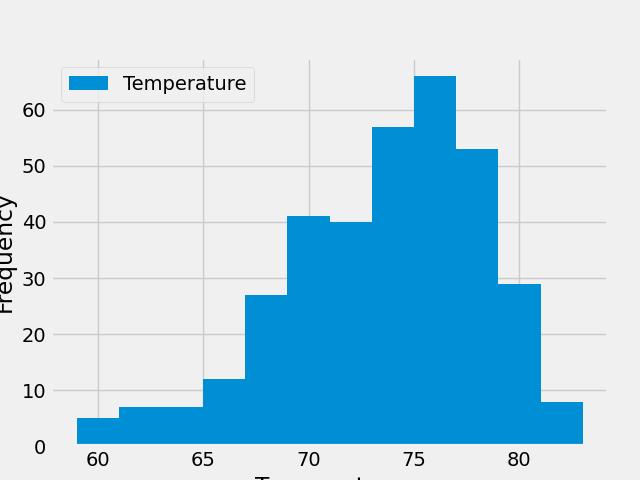

Text(0.5, 0, 'Temperature')

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results2 = session.query(M.tobs).filter(M.date >= query_date).filter(M.station == "USC00519281").all()
temp_df = pd.DataFrame(results2,columns=['tobs'])
temp_df = temp_df.rename(columns={'tobs': 'Temperature'})
temp_df.plot.hist(bins=12)
plt.xlabel("Temperature")